In [135]:
import torch
from option import get_option
from models.FasterRCNN import FasterRCNN

opt = get_option()
model = FasterRCNN(num_classes=opt.num_classes)

ckpt = torch.load(
    "/media/hdd/sonwe1e/Detection/Data/Line/checkpoints/baselinev1/epoch=175_train_loss=0.041.ckpt"
)
for k in list(ckpt["state_dict"].keys()):
    if k.startswith("model."):
        ckpt["state_dict"][k[6:]] = ckpt["state_dict"].pop(k)
    
model.load_state_dict(ckpt["state_dict"])
model.cuda(5).eval()

FasterRCNN(
  (backbone): FeatureListNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps

In [142]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
import numpy as np

valid_transform = A.Compose(
    [
        A.Resize(opt.image_size, opt.image_size),
        A.Normalize(),
        ToTensorV2(),
    ],
    # bbox_params=A.BboxParams(
    #     format="pascal_voc", min_visibility=0.1, label_fields=["class_labels"]
    # ),
)

image_path = "/media/hdd/sonwe1e/Detection/Data/Line/train/images/rand_final_3hang_lie_text_38.png"

image = Image.open(image_path)
image_tensor = valid_transform(image=np.array(image))["image"]
image_tensor = image_tensor.unsqueeze(0).cuda(5)
with torch.no_grad():
    output = model(image_tensor)

In [143]:
(
    features,
    rpn_locs,
    rpn_scores,
    rois,
    roi_indices,
    anchors,
    cls_scores,
    bbox_deltas,
) = output

print(f'features: {features.shape}')
print(f'rpn_locs: {rpn_locs.shape}')
print(f'rpn_scores: {rpn_scores.shape}')
print(f'rois: {rois.shape}')
print(f'roi_indices: {roi_indices.shape}')
print(f'anchors: {anchors.shape}')
print(f'cls_scores: {cls_scores.shape}')
print(f'bbox_deltas: {bbox_deltas.shape}')

features: torch.Size([1, 1024, 16, 16])
rpn_locs: torch.Size([1, 2304, 4])
rpn_scores: torch.Size([1, 2304, 2])
rois: torch.Size([1, 600, 4])
roi_indices: torch.Size([1, 600])
anchors: torch.Size([2304, 4])
cls_scores: torch.Size([600, 2])
bbox_deltas: torch.Size([600, 8])


In [144]:
from utils import loc2bbox
from typing import Tuple
from torchvision.ops import nms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


def get_cls_prob(cls_scores: torch.Tensor) -> torch.Tensor:
    """
    将分类分数转换为概率分布。

    参数:
    - cls_scores (torch.Tensor): 分类分数，形状为 (N, num_classes)。

    返回:
    - cls_prob (torch.Tensor): 分类概率，形状为 (N, num_classes)。
    """
    cls_prob = F.softmax(cls_scores, dim=1)
    return cls_prob
def get_pred_boxes(
    cls_prob: torch.Tensor,
    bbox_deltas: torch.Tensor,
    rois: torch.Tensor,
    loc_normalize_std: torch.Tensor = torch.tensor([0.1, 0.1, 0.2, 0.2]),
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    获取预测的边界框和对应的类别标签。

    参数:
    - cls_prob (torch.Tensor): 分类概率，形状为 (N, num_classes)。
    - bbox_deltas (torch.Tensor): 定位偏移量，形状为 (N, num_classes, 4)。
    - rois (torch.Tensor): 原始 ROIs，形状为 (N, 4)。
    - loc_normalize_std (torch.Tensor): 定位偏移量的标准化参数，形状为 (4,).

    返回:
    - pred_boxes (torch.Tensor): 预测的边界框，形状为 (N, 4)。
    - pred_labels (torch.Tensor): 预测的类别标签，形状为 (N,)。
    - pred_scores (torch.Tensor): 预测的置信度分数，形状为 (N,)。
    """
    # 获取每个 ROI 的预测类别
    pred_labels = torch.argmax(cls_prob, dim=1)  # (N,)
    # 获取每个 ROI 的预测分数
    pred_scores = torch.max(cls_prob, dim=1).values  # (N,)

    # 根据预测类别选择对应的 bbox_deltas
    # bbox_deltas 的形状为 (N, num_classes, 4)
    # 需要根据 pred_labels 选择每个 ROI 的对应 deltas
    indices = pred_labels.view(-1, 1, 1).expand(-1, 1, 4)  # (N, 1, 4)
    bbox_deltas_pred = bbox_deltas.gather(1, indices).squeeze(1)  # (N, 4)
    bbox_deltas_pred = bbox_deltas_pred * loc_normalize_std.view(1, 4).to(
        bbox_deltas_pred
    .device)  # 反标准化

    # 解码最终的边界框
    pred_boxes = loc2bbox(rois, bbox_deltas_pred)  # (N, 4)
    return pred_boxes, pred_labels, pred_scores

def apply_nms(
    pred_boxes: torch.Tensor,
    pred_scores: torch.Tensor,
    pred_labels: torch.Tensor,
    iou_threshold: float = 0.5,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    对预测的边界框应用非极大值抑制（NMS）。

    参数:
    - pred_boxes (torch.Tensor): 预测的边界框，形状为 (N, 4)。
    - pred_scores (torch.Tensor): 预测的置信度分数，形状为 (N,)。
    - pred_labels (torch.Tensor): 预测的类别标签，形状为 (N,)。
    - iou_threshold (float): IoU 阈值，用于 NMS。

    返回:
    - keep_boxes (torch.Tensor): 保留的边界框，形状为 (M, 4)。
    - keep_labels (torch.Tensor): 保留的类别标签，形状为 (M,)。
    - keep_scores (torch.Tensor): 保留的置信度分数，形状为 (M,)。
    """
    keep_boxes = []
    keep_labels = []
    keep_scores = []

    unique_labels = pred_labels.unique()
    for c in unique_labels:
        if c == 0:
            continue  # 通常 0 是背景类别，不需要处理
        inds = torch.where(pred_labels == c)[0]
        boxes = pred_boxes[inds]
        scores = pred_scores[inds]
        keep = nms(boxes, scores, iou_threshold)
        keep_boxes.append(boxes[keep])
        keep_labels.append(pred_labels[inds][keep])
        keep_scores.append(scores[keep])

    if len(keep_boxes) > 0:
        keep_boxes = torch.cat(keep_boxes, dim=0)
        keep_labels = torch.cat(keep_labels, dim=0)
        keep_scores = torch.cat(keep_scores, dim=0)
    else:
        keep_boxes = torch.empty((0, 4), dtype=torch.float32)
        keep_labels = torch.empty((0,), dtype=torch.int64)
        keep_scores = torch.empty((0,), dtype=torch.float32)

    return keep_boxes, keep_labels, keep_scores


def plot_detections(
    image: Image.Image,
    boxes: torch.Tensor,
    labels: torch.Tensor,
    scores: torch.Tensor,
    class_names: list,
    score_threshold: float = 0.5,
):
    """
    在图像上绘制检测结果。

    参数:
    - image (PIL.Image.Image): 原始图像。
    - boxes (torch.Tensor): 边界框，形状为 (N, 4)。
    - labels (torch.Tensor): 类别标签，形状为 (N,)。
    - scores (torch.Tensor): 置信度分数，形状为 (N,)。
    - class_names (list): 类别名称列表，索引对应标签。
    - score_threshold (float): 置信度阈值，低于该值的检测结果将被忽略。
    """
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        if score < score_threshold:
            continue
        x1, y1, x2, y2 = box.tolist()
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle(
            (x1, y1), width, height, linewidth=2, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(
            x1,
            y1 - 5,
            f"{class_names[label]}: {score:.2f}",
            color="r",
            fontsize=12,
            backgroundcolor="white",
        )

    plt.axis("off")
    plt.show()


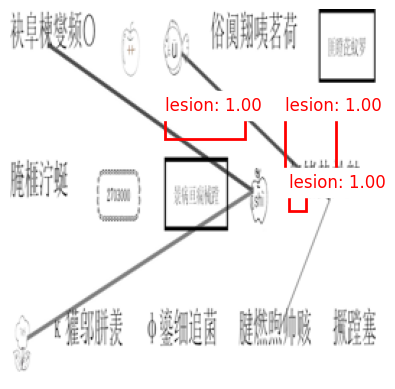

In [145]:
# 假设你有类别名称列表
class_names = ['x',"lesion"]  # 示例

# 将 ROIs 和定位偏移量映射到最终的边界框
cls_prob = get_cls_prob(cls_scores)  # (num_rois, num_classes)
pred_boxes, pred_labels, pred_scores = get_pred_boxes(cls_prob, bbox_deltas.reshape(-1, 2, 4), rois[0])

# 应用 NMS
keep_boxes, keep_labels, keep_scores = apply_nms(
    pred_boxes, pred_scores, pred_labels, iou_threshold=0.7
)

# 绘制检测结果
plot_detections(
    image.resize((opt.image_size, opt.image_size)),
    keep_boxes,
    keep_labels,
    keep_scores,
    class_names,
    score_threshold=0.6,
)


tensor(1., device='cuda:5')
tensor(1., device='cuda:5')
tensor(1., device='cuda:5')
tensor(1., device='cuda:5')
tensor(1., device='cuda:5')


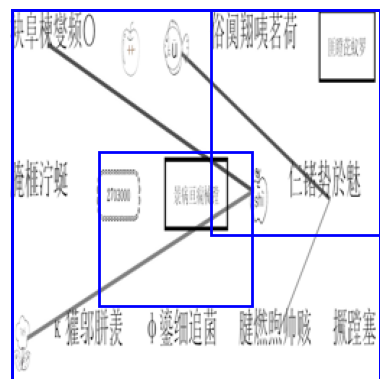

In [146]:
# 将 rois 的前 5 个画出来
fig, ax = plt.subplots(1)
ax.imshow(image.resize((opt.image_size, opt.image_size)))

for _, roi in enumerate(rois[0][:5
                                ]):
    x1, y1, x2, y2 = map(int, roi.tolist())
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle(
        (x1, y1), width, height, linewidth=2, edgecolor="b", facecolor="none"
    )
    ax.add_patch(rect)
    print(pred_scores[_])

plt.axis("off")
plt.show()


In [141]:
cls_scores[:10]


tensor([[-13.8115,  13.1030],
        [-13.8324,  12.8856],
        [-16.8102,  16.0787],
        [-16.9902,  15.9331],
        [-14.9300,  14.0298],
        [-14.9300,  14.0298],
        [-14.9300,  14.0298],
        [-14.9300,  14.0298],
        [-14.9300,  14.0298],
        [-14.9300,  14.0298]], device='cuda:5')